# Exploration of execution

Execution 

```{bash}
cd /home/ec2-user/SageMaker/foodi-ml
source activate python3
export DATA_PATH=/home/ec2-user/SageMaker/data/
python run.py options/adapt/foodi-ml/i2t.yaml

#watch -n 1 "nvidia-smi"
```

In [1]:
import os
os.chdir("/home/ec2-user/SageMaker/foodi-ml/")

In [2]:
#!pip install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl

In [3]:
#!pip install -r requirements.txt

In [4]:
import os
import torch
from tqdm import tqdm
from addict import Dict

import params
from retrieval.train import train
from retrieval.utils import helper
from retrieval.model import loss
from retrieval.model.model import Retrieval
from retrieval.data.loaders import get_loaders
from retrieval.utils.logger import create_logger
from retrieval.utils.helper import load_model
from retrieval.utils.file_utils import load_yaml_opts, parse_loader_name

# Functions

In [5]:
def get_data_path(opt):
    if 'DATA_PATH' not in os.environ:
        if not opt.dataset.data_path:
            raise Exception('''
                DATA_PATH not specified.
                Please, run "$ export DATA_PATH=/path/to/dataset"
                or add path to yaml file
            ''')
        return opt.dataset.data_path
    else:
        return os.environ['DATA_PATH']

In [6]:
def get_tokenizers(train_loader):
    tokenizers = train_loader.dataset.tokenizer
    if type(tokenizers) != list:
        tokenizers = [tokenizers]
    return tokenizers

In [7]:
def set_criterion(opt, model):
    if 'name' in opt.criterion:
        logger.info(opt.criterion)
        multimodal_criterion = loss.get_loss(**opt.criterion)
        multilanguage_criterion = loss.get_loss(**opt.criterion)
    else:
        multimodal_criterion = loss.ContrastiveLoss(**opt.criterion)
        multilanguage_criterion = loss.ContrastiveLoss(**opt.ml_criterion)
    set_model_criterion(opt, model, multilanguage_criterion, multimodal_criterion)
    # return multimodal_criterion, multilanguage_criterion


def set_model_criterion(opt, model, multilanguage_criterion, multimodal_criterion):
    model.mm_criterion = multimodal_criterion
    model.ml_criterion = None
    if len(opt.dataset.adapt.data) > 0:
        model.ml_criterion = multilanguage_criterion

# Run

In [8]:
os.environ["DATA_PATH"] = "/home/ec2-user/SageMaker/data/"

In [9]:
options = "options/adapt/foodi-ml/i2t.yaml"

In [10]:
args = {
    "options": options,
}
args = Dict(args)
opt = load_yaml_opts(args.options)

In [11]:
logger = create_logger(level='debug' if opt.engine.debug else 'info')
#logger.info(f'Used args   : \n{args}')
#logger.info(f'Used options: \n{opt}')

In [12]:
# Get path of the data
data_path = get_data_path(opt)

In [13]:
# Get loaders
train_loader, val_loaders, adapt_loaders = get_loaders(data_path, args.local_rank, opt)

2021-08-24 17:13:06,904 - [INFO    ] - Loaded vocab containing 245967 tokens
2021-08-24 17:13:06,905 - [INFO    ] - Loaded from .vocab_cache/foodiml_vocab.json.
2021-08-24 17:13:06,905 - [INFO    ] - Created tokenizer with init 245967 tokens.
2021-08-24 17:13:08,143 - [INFO    ] - [FoodiML] Loaded 14052 images annotated 
2021-08-24 17:13:08,337 - [INFO    ] - Loaded vocab containing 245967 tokens
2021-08-24 17:13:08,337 - [INFO    ] - Loaded from .vocab_cache/foodiml_vocab.json.
2021-08-24 17:13:08,338 - [INFO    ] - Created tokenizer with init 245967 tokens.
2021-08-24 17:13:08,589 - [INFO    ] - [FoodiML] Loaded 2897 images annotated 
2021-08-24 17:13:08,592 - [INFO    ] - Adapt loaders: 0


In [14]:
tokenizers = get_tokenizers(train_loader)

In [15]:
%%time
model = Retrieval(**opt.model, tokenizers=tokenizers)

2021-08-24 15:15:12,617 - [INFO    ] - Image encoder created: ('full_image',)
2021-08-24 15:15:14,868 - [INFO    ] - Text encoder created: gru_glove
2021-08-24 15:15:14,938 - [INFO    ] - Created similarity: AdaptiveEmbeddingI2T(
  (norm): Normalization(
    (norm): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (adapt_txt): ADAPT(
    (fc_gamma): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
    )
    (fc_beta): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
    )
  )
  (fovea): Fovea(smooth=10,train_smooth: False)
)
2021-08-24 15:15:17,946 - [INFO    ] - Setting devices: img: cuda,txt: cuda, loss: cuda
2021-08-24 15:15:17,947 - [INFO    ] - Using similarity: ('adapt_i2t',)


CPU times: user 5.37 s, sys: 1.56 s, total: 6.93 s
Wall time: 6.84 s


In [16]:
print_fn = (lambda x: x) if not model.master else tqdm.write

In [17]:
set_criterion(opt, model)

In [18]:
# Trainer
trainer = train.Trainer(
        model=model,
        args=opt,
        sysoutlog=print_fn,
        path=opt.exp.outpath,
        world_size=1 # TODO
)

In [19]:
trainer.setup_optim(
        lr=opt.optimizer.lr,
        lr_scheduler=opt.optimizer.lr_scheduler,
        clip_grad=opt.optimizer.grad_clip,
        log_grad_norm=False,
        log_histograms=False,
        optimizer=opt.optimizer,
        freeze_modules=opt.model.freeze_modules
)

2021-08-24 15:15:27,093 - [INFO    ] - lr 0.001
2021-08-24 15:15:27,093 - [INFO    ] - [0.5, 2.0, 4000]
2021-08-24 15:15:27,094 - [INFO    ] - [10000, 20000, 3000]


Freezing model.txt_enc.embed.glove
lr: 0.001, #layers: 478, #params: 172,889,812
Total Params: 175,393,912, 


In [20]:
trainer.fit(
        train_loader=train_loader,
        valid_loaders=val_loaders,
        lang_loaders=adapt_loaders,
        nb_epochs=opt.engine.nb_epochs,
        valid_interval=opt.engine.valid_interval,
        log_interval=opt.engine.print_freq
)

logs/foodi-ml/adapt_i2t/ already exists! Do you want to rewrite it? [y/n]  y


Steps :   0%|          | 0/1088 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered

# EXPLORE

In [26]:
torch.__version__

'1.1.0'

In [ ]:
#!pip install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-win_amd64.whl

In [8]:
import torch
a = torch.randn(3, 3, device="cuda:0")
a = torch.mm(a, a.t()) # make symmetric positive-definite
torch.cholesky(a)

tensor([[ 1.5002,  0.0000,  0.0000],
        [-0.5008,  1.0633,  0.0000],
        [ 0.0642,  0.4374,  1.6847]], device='cuda:0')

## Data Loaders

2021-08-24 17:13:31,629 - [WARNING ] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


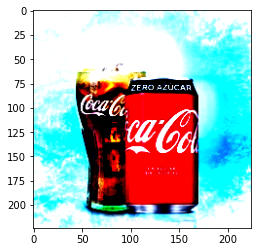

In [16]:
index = 0
image_id = train_loader.dataset.data_wrapper.image_ids[index]
caption = train_loader.dataset.captions[index]
cap_tokens = train_loader.dataset.tokenizer(caption)
image = train_loader.dataset.load_img(image_id)

import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)  )

In [22]:
import numpy as np
np.max(list(train_loader.dataset.data_wrapper.image_ids))

2021209

In [18]:
len(train_loader.dataset.captions)

14052

In [75]:
image.shape

torch.Size([3, 224, 224])

In [76]:
# Check valid loader
#image_id2 = val_loaders[0].dataset.data_wrapper.image_ids[index]
#image2 = val_loaders[0].dataset.load_img(image_id2)
#import matplotlib.pyplot as plt
#plt.imshow(  image2.permute(1, 2, 0)  )